In [3]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A

from timm.data import Mixup
from timm.data.random_erasing import RandomErasing as RandomErasingTimm
from timm.loss import SoftTargetCrossEntropy
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d
from timm.models.layers.blur_pool import BlurPool2d

In [4]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [5]:
VERSION  = "NB_EXP_019"
EXP_NAME = f"{VERSION}_convnext_base"
MODEL_FOLDER = Path(f'/runs/{VERSION}'); os.makedirs(MODEL_FOLDER, exist_ok=True)

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

TIMM_MODEL = "convnext_base_384_in22ft1k"

NFOLDS = 5
BS = 32
SZ = 384

TRAIN_AUG = A.Compose([
    A.Resize(SZ, SZ),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=360, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
    A.CoarseDropout(max_height=int(32*(SZ/512)), max_width=int(32*(SZ/512)), p=0.75), 
])

CROP_PCT = 1.0
SCALE_SZ = int(math.floor(SZ / CROP_PCT))
VALID_AUG = A.Compose([A.Resize(SCALE_SZ, SCALE_SZ), A.CenterCrop(SZ, SZ)])

In [6]:
all_df = pd.read_csv(CSV_PATH)

folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


In [7]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)


class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0: aug_img = self.train_aug(image=np.array(img))['image']
        else            : aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [8]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]

In [9]:
def get_dls(fold:int, bs:int, *args, **kwargs):
    
    item_tfms = [ToTensor, AlbumentationsTransform(TRAIN_AUG, VALID_AUG)]
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

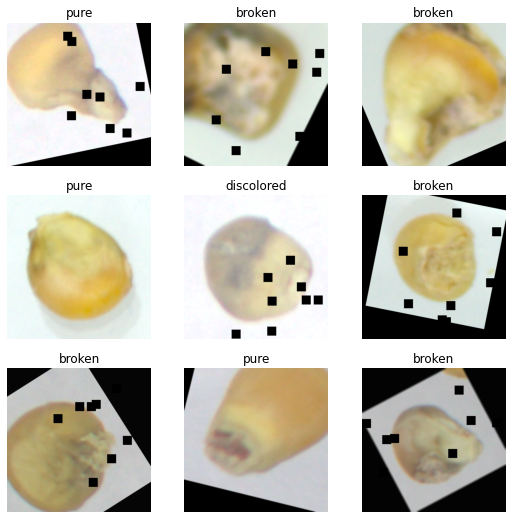

In [10]:
dls = get_dls(0, BS)
dls.show_batch()

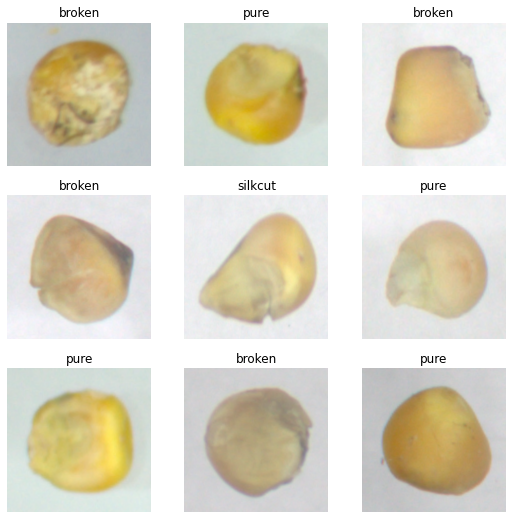

In [11]:
dls.valid.show_batch()

In [12]:
def build_experiment(fold:int = 0, pretrained:bool=True):
    print(f'model:{TIMM_MODEL}; pretrained:{pretrained}')
    print(f'fold:{fold}; sz:{SZ}; bs:{BS}')
    
    dls = get_dls(fold, bs=BS)
    
    learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=pretrained,
                           loss_func=CrossEntropyLossFlat(), metrics=[accuracy] ).to_fp16()
    return dls, learn


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:convnext_base_384_in22ft1k; pretrained:True
fold:0; sz:384; bs:32


SuggestedLRs(valley=0.0006918309954926372, slide=0.0014454397605732083)
CPU: 1766/304/3901 MB | GPU: 1032/5764/2094 MB | Time 0:00:35.612 | (Consumed/Peaked/Used Total)


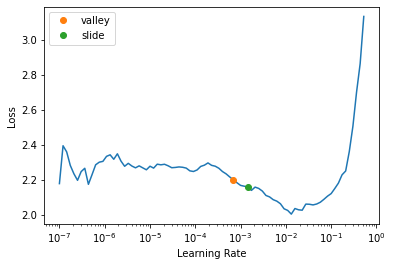

In [15]:
set_seed(42); set_fast_norm()

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):      
    dls, learn = build_experiment(0)
    print(learn.lr_find(suggest_funcs=(valley, slide)))

In [16]:
n_epo = 15; base_lr = 0.002;
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_mixup"

In [17]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, 
                        save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            print()
            print('*' * 100)
            print(f'Training fold {fold_idx}')
            print('*' * 100)
        
            dls, learn = build_experiment(fold_idx)
            print(f'epochs:{n_epo}; base_lr:{base_lr}')
            
            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   MixUp(0.4),
                   WandbCallback(log_preds=None)]
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 0
****************************************************************************************************
model:convnext_base_384_in22ft1k; pretrained:True
fold:0; sz:384; bs:32
epochs:15; base_lr:0.002


epoch,train_loss,valid_loss,accuracy,time
0,1.223089,0.823900,0.671204,02:17


Better model found at epoch 0 with accuracy value: 0.6712042093276978.


epoch,train_loss,valid_loss,accuracy,time
0,0.983633,0.677530,0.722862,02:55
1,0.924304,0.632621,0.751832,02:55
2,0.861201,0.619254,0.747295,02:55
3,0.842146,0.588217,0.767539,02:55
4,0.819580,0.544916,0.783944,02:55
5,0.787169,0.542297,0.782897,02:55
6,0.767812,0.518157,0.790925,02:55
7,0.739723,0.518620,0.797208,02:55
8,0.743875,0.509466,0.797906,02:55
9,0.715218,0.506102,0.796161,02:55


Better model found at epoch 0 with accuracy value: 0.7228621244430542.
Better model found at epoch 1 with accuracy value: 0.7518324851989746.
Better model found at epoch 3 with accuracy value: 0.7675392627716064.
Better model found at epoch 4 with accuracy value: 0.7839441299438477.
Better model found at epoch 6 with accuracy value: 0.7909249663352966.
Better model found at epoch 7 with accuracy value: 0.7972076535224915.
Better model found at epoch 8 with accuracy value: 0.7979057431221008.
Better model found at epoch 10 with accuracy value: 0.8045375347137451.
Better model found at epoch 12 with accuracy value: 0.809424102306366.
CPU: 600/235/4503 MB | GPU: 1314/10924/3408 MB | Time 0:46:35.052 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 1
****************************************************************************************************
model:convnext_base_384_in22ft1k; pretrained:True
fold:1; sz:384; bs:32
epochs:15; base_lr:0.002


epoch,train_loss,valid_loss,accuracy,time
0,1.240052,0.814249,0.664572,02:18


Better model found at epoch 0 with accuracy value: 0.6645724177360535.


epoch,train_loss,valid_loss,accuracy,time
0,0.988601,0.693272,0.723211,02:55
1,0.912069,0.637891,0.746946,02:55
2,0.856171,0.598669,0.759511,02:54
3,0.839732,0.575328,0.765794,02:54
4,0.816073,0.551449,0.779058,02:55
5,0.785492,0.529505,0.786736,02:54
6,0.778369,0.523849,0.793368,02:54
7,0.736936,0.520789,0.792670,02:55
8,0.748824,0.511383,0.790925,02:55
9,0.728860,0.511937,0.795462,02:55


Better model found at epoch 0 with accuracy value: 0.7232111692428589.
Better model found at epoch 1 with accuracy value: 0.7469459176063538.
Better model found at epoch 2 with accuracy value: 0.7595113515853882.
Better model found at epoch 3 with accuracy value: 0.765794038772583.
Better model found at epoch 4 with accuracy value: 0.7790575623512268.
Better model found at epoch 5 with accuracy value: 0.7867364883422852.
Better model found at epoch 6 with accuracy value: 0.7933682203292847.
Better model found at epoch 9 with accuracy value: 0.7954624891281128.
Better model found at epoch 10 with accuracy value: 0.8048865795135498.
Better model found at epoch 12 with accuracy value: 0.8090750575065613.
CPU: 97/310/4601 MB | GPU: 319/11667/3727 MB | Time 0:46:31.828 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 2
****************************************************************************************************
model:convnext_base_384_in22ft1k; pretrained:True
fold:2; sz:384; bs:32
epochs:15; base_lr:0.002


epoch,train_loss,valid_loss,accuracy,time
0,1.207007,0.851318,0.658170,02:17


Better model found at epoch 0 with accuracy value: 0.6581704020500183.


epoch,train_loss,valid_loss,accuracy,time
0,0.960194,0.674898,0.729050,02:54
1,0.924990,0.639920,0.741620,02:54
2,0.862997,0.606714,0.762919,02:54
3,0.845542,0.571165,0.768855,02:54
4,0.812272,0.550587,0.777933,02:54
5,0.783656,0.551205,0.788059,02:54
6,0.755781,0.530582,0.789804,02:54
7,0.748871,0.519843,0.796439,02:54
8,0.750733,0.500232,0.805517,02:54
9,0.729275,0.501612,0.802025,02:53


Better model found at epoch 0 with accuracy value: 0.7290502786636353.
Better model found at epoch 1 with accuracy value: 0.7416201233863831.
Better model found at epoch 2 with accuracy value: 0.762919008731842.
Better model found at epoch 3 with accuracy value: 0.7688547372817993.
Better model found at epoch 4 with accuracy value: 0.7779329419136047.
Better model found at epoch 5 with accuracy value: 0.7880586385726929.
Better model found at epoch 6 with accuracy value: 0.7898044586181641.
Better model found at epoch 7 with accuracy value: 0.7964385747909546.
Better model found at epoch 8 with accuracy value: 0.80551677942276.
Better model found at epoch 10 with accuracy value: 0.8125.
CPU: -21/195/4579 MB | GPU: 258/11354/3985 MB | Time 0:46:16.355 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 3
****************************************************************************************************
model:convnext_base_384_in22ft1k; pretrained:True
fold:3; sz:384; bs:32
epochs:15; base_lr:0.002


epoch,train_loss,valid_loss,accuracy,time
0,1.220600,0.926409,0.655377,02:17


Better model found at epoch 0 with accuracy value: 0.6553770899772644.


epoch,train_loss,valid_loss,accuracy,time
0,0.977169,0.684886,0.721718,02:54
1,0.930606,0.634690,0.746508,02:54
2,0.878805,0.588323,0.771299,02:54
3,0.844750,0.556425,0.781075,02:54
4,0.817433,0.545908,0.783170,02:54
5,0.798045,0.535571,0.789106,02:54
6,0.765026,0.504857,0.801327,02:54
7,0.764716,0.486015,0.805168,02:54
8,0.738134,0.481565,0.811453,02:54
9,0.731941,0.488523,0.803422,02:54


Better model found at epoch 0 with accuracy value: 0.721717894077301.
Better model found at epoch 1 with accuracy value: 0.7465083599090576.
Better model found at epoch 2 with accuracy value: 0.771298885345459.
Better model found at epoch 3 with accuracy value: 0.7810754179954529.
Better model found at epoch 4 with accuracy value: 0.7831704020500183.
Better model found at epoch 5 with accuracy value: 0.7891061305999756.
Better model found at epoch 6 with accuracy value: 0.8013268113136292.
Better model found at epoch 7 with accuracy value: 0.8051676154136658.
Better model found at epoch 8 with accuracy value: 0.8114525079727173.
Better model found at epoch 11 with accuracy value: 0.8170391321182251.
Better model found at epoch 12 with accuracy value: 0.8173882961273193.
Better model found at epoch 13 with accuracy value: 0.8191340565681458.
CPU: -7/183/4571 MB | GPU: -100/11412/3885 MB | Time 0:46:18.969 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
De


****************************************************************************************************
Training fold 4
****************************************************************************************************
model:convnext_base_384_in22ft1k; pretrained:True
fold:4; sz:384; bs:32
epochs:15; base_lr:0.002


epoch,train_loss,valid_loss,accuracy,time
0,1.186412,0.888020,0.665154,02:17


Better model found at epoch 0 with accuracy value: 0.6651536226272583.


epoch,train_loss,valid_loss,accuracy,time
0,1.001996,0.661586,0.736732,02:54
1,0.918083,0.596964,0.763967,02:54
2,0.870048,0.586419,0.766061,02:54
3,0.836381,0.570142,0.779330,02:54
4,0.807776,0.524352,0.789106,02:54
5,0.808300,0.522377,0.795391,02:54
6,0.761363,0.490212,0.801327,02:54
7,0.756554,0.493956,0.804469,02:54
8,0.761917,0.494353,0.806215,02:54
9,0.735691,0.483493,0.806215,02:54


Better model found at epoch 0 with accuracy value: 0.7367318272590637.
Better model found at epoch 1 with accuracy value: 0.7639665007591248.
Better model found at epoch 2 with accuracy value: 0.7660614252090454.
Better model found at epoch 3 with accuracy value: 0.7793295979499817.
Better model found at epoch 4 with accuracy value: 0.7891061305999756.
Better model found at epoch 5 with accuracy value: 0.7953910827636719.
Better model found at epoch 6 with accuracy value: 0.8013268113136292.
Better model found at epoch 7 with accuracy value: 0.8044692873954773.
Better model found at epoch 8 with accuracy value: 0.8062151074409485.
Better model found at epoch 10 with accuracy value: 0.8142458200454712.
Better model found at epoch 12 with accuracy value: 0.8184357285499573.
CPU: -12/199/4559 MB | GPU: 230/11218/4115 MB | Time 0:46:24.308 | (Consumed/Peaked/Used Total)


In [18]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
#         # hflip + vflip augs
#         tst_dl_hlip_vflip = dls.valid.new()
#         tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:convnext_base_384_in22ft1k; pretrained:False
fold:0; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_019_convnext_base_384_bs32_epo15_mixup_CV_00' (00)


* Accuracy : 0.8062826991081238

model:convnext_base_384_in22ft1k; pretrained:False
fold:1; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_019_convnext_base_384_bs32_epo15_mixup_CV_01' (01)


* Accuracy : 0.8125654458999634

model:convnext_base_384_in22ft1k; pretrained:False
fold:2; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_019_convnext_base_384_bs32_epo15_mixup_CV_02' (02)


* Accuracy : 0.8145949840545654

model:convnext_base_384_in22ft1k; pretrained:False
fold:3; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_019_convnext_base_384_bs32_epo15_mixup_CV_03' (03)


* Accuracy : 0.8208798766136169

model:convnext_base_384_in22ft1k; pretrained:False
fold:4; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_019_convnext_base_384_bs32_epo15_mixup_CV_04' (04)


* Accuracy : 0.81948322057724

CPU: 50/275/4610 MB | GPU: -1462/2200/2653 MB | Time 0:03:01.196 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.80628, 0.81257, 0.81459, 0.82088, 0.81948]
Avg: 0.81476
Std: 0.00522


In [20]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
#         # hflip + vflip augs
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:convnext_base_384_in22ft1k; pretrained:False
fold:0; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_019_convnext_base_384_bs32_epo15_mixup_CV_00' (00)


* Accuracy : 0.8090750575065613

model:convnext_base_384_in22ft1k; pretrained:False
fold:1; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_019_convnext_base_384_bs32_epo15_mixup_CV_01' (01)


* Accuracy : 0.8171029686927795

model:convnext_base_384_in22ft1k; pretrained:False
fold:2; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_019_convnext_base_384_bs32_epo15_mixup_CV_02' (02)


* Accuracy : 0.8156424760818481

model:convnext_base_384_in22ft1k; pretrained:False
fold:3; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_019_convnext_base_384_bs32_epo15_mixup_CV_03' (03)


* Accuracy : 0.8173882961273193

model:convnext_base_384_in22ft1k; pretrained:False
fold:4; sz:384; bs:32
==> Load checkpoint from : 'NB_EXP_019_convnext_base_384_bs32_epo15_mixup_CV_04' (04)


* Accuracy : 0.8201815485954285

CPU: -16/47/4602 MB | GPU: 1174/1186/4234 MB | Time 0:03:50.492 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.80908, 0.8171, 0.81564, 0.81739, 0.82018]
Avg: 0.81588
Std: 0.00371
